In [30]:
import pandas as pd

# 1) 정제된 데이터 다시 로드
df = pd.read_csv("total_clean.csv", parse_dates=["Date"])

# 2) 숫자 컬럼 타입 다시 한 번 확실히 맞추기
num_cols = ["CustomerID", "TotalCost", "Quantity", "EffectivePrice"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

print(df.dtypes)
print(df.head())


CustomerID                 float64
Date                datetime64[ns]
MeterCategory               object
MeterSubCategory            object
MeterName                   object
ChargeType                  object
EffectivePrice             float64
MaskedSub                   object
Quantity                   float64
TotalCost                  float64
dtype: object
   CustomerID       Date     MeterCategory  \
0       100.0 2025-08-20  Virtual Machines   
1       100.0 2025-08-21  Virtual Machines   
2       100.0 2025-08-10  Virtual Machines   
3       100.0 2025-08-29  Virtual Machines   
4       100.0 2025-08-09  Virtual Machines   

                       MeterSubCategory MeterName ChargeType  EffectivePrice  \
0  Virtual Machines Dsv5 Series Windows    D8s v5      Usage          0.5502   
1  Virtual Machines Dsv5 Series Windows    D8s v5      Usage          0.5502   
2  Virtual Machines Dsv5 Series Windows    D8s v5      Usage          0.5502   
3  Virtual Machines Dsv5 Series Windows

In [31]:
cust_id = 500  # 다른 고객 보고 싶으면 숫자만 바꾸면 됨

# 1) 해당 고객 데이터만 필터링 + 날짜별 TotalCost 합계
ts = (
    df[df["CustomerID"] == cust_id]
    .groupby("Date")["TotalCost"]
    .sum()
    .sort_index()
)

print("고객 ID:", cust_id)
print("데이터 포인트 개수:", len(ts))
print(ts.head())
print("날짜 범위:", ts.index.min(), "~", ts.index.max())


고객 ID: 500
데이터 포인트 개수: 183
Date
2024-04-01    6.296201e+07
2024-04-02    6.088439e+07
2024-04-03    5.682108e+07
2024-04-04    5.805774e+07
2024-04-05    5.905906e+07
Name: TotalCost, dtype: float64
날짜 범위: 2024-04-01 00:00:00 ~ 2024-09-30 00:00:00


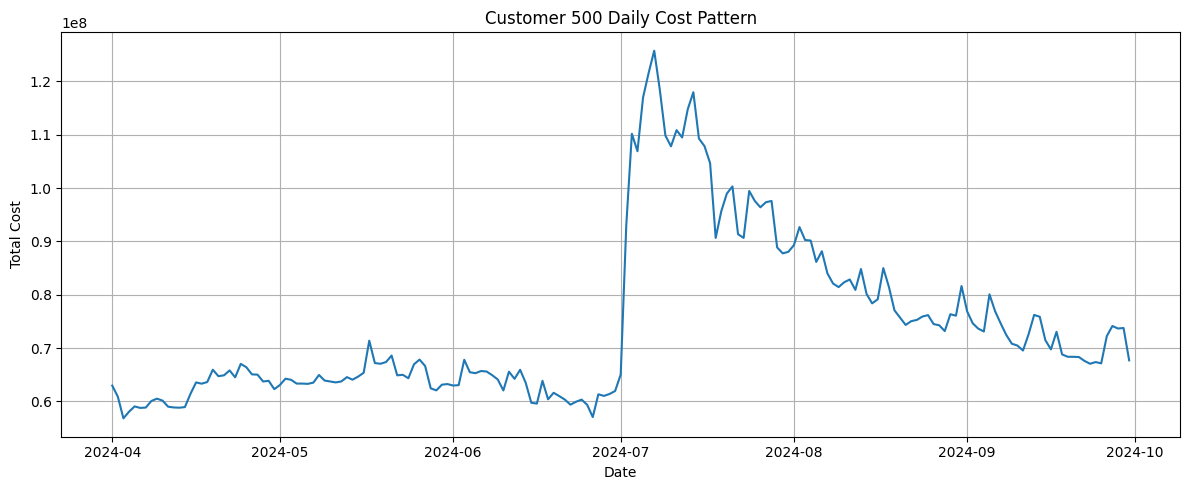

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(ts.index, ts.values)
plt.title(f"Customer {cust_id} Daily Cost Pattern")
plt.xlabel("Date")
plt.ylabel("Total Cost")
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
split_point = int(len(ts) * 0.8)

train = ts.iloc[:split_point]
test  = ts.iloc[split_point:]

print("Train size:", len(train))
print("Test size :", len(test))
print("Train 기간:", train.index.min(), "~", train.index.max())
print("Test 기간 :", test.index.min(), "~", test.index.max())


Train size: 146
Test size : 37
Train 기간: 2024-04-01 00:00:00 ~ 2024-08-24 00:00:00
Test 기간 : 2024-08-25 00:00:00 ~ 2024-09-30 00:00:00


In [34]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()

train_values = train.values.reshape(-1, 1)
test_values  = test.values.reshape(-1, 1)

train_scaled = scaler.fit_transform(train_values)
test_scaled  = scaler.transform(test_values)

print("✅ 정규화 완료")
print("train shape:", train_scaled.shape)
print("test shape :", test_scaled.shape)
print("train min/max:", train_scaled.min(), train_scaled.max())
print("test min/max :", test_scaled.min(), test_scaled.max())


✅ 정규화 완료
train shape: (146, 1)
test shape : (37, 1)
train min/max: 0.0 1.0
test min/max : 0.14841794539887532 0.3599223562240855


In [35]:
# 슬라이딩 윈도우 생성 함수
def create_sequences(data, window_size=30):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
    return np.array(X)

WINDOW_SIZE = 7

X_train = create_sequences(train_scaled, WINDOW_SIZE)
X_test  = create_sequences(test_scaled, WINDOW_SIZE)

print("✅ 시퀀스 생성 완료")
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)


✅ 시퀀스 생성 완료
X_train shape: (139, 7, 1)
X_test shape : (30, 7, 1)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

# 모델 구조 정의
model = Sequential([
    LSTM(32, activation="relu", input_shape=(WINDOW_SIZE, 1), return_sequences=False),
    RepeatVector(WINDOW_SIZE),
    LSTM(32, activation="relu", return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer="adam", loss="mse")

model.summary()


C:\dev\ds-playground\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 32)               │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 7, 1)                │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
rlr = ReduceLROnPlateau(monitor="val_loss",
                        factor=0.5,
                        patience=5,
                        min_lr=1e-5)

history = model.fit(
    X_train, X_train,          # 오토인코더라서 입력=정답
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    shuffle=False,
    callbacks=[early_stop, rlr]
)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0221 - val_loss: 0.0233 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0220 - val_loss: 0.0235 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0219 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0218 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0217 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0215 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0214 - val_loss: 0.0226 - learning_rate: 0.0010
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0212 - val_loss: 0.0225 - learning_rate: 0.0010
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0211 - val_loss: 0.0224 - learning_rate: 0.0010
Epoch 10/100
4/4 ━━━━━━━━━━━

In [21]:
# 학습 데이터 재구성
X_train_pred = model.predict(X_train)

# 재구성 오차 (MSE)
train_mse = np.mean(np.square(X_train_pred - X_train), axis=(1,2))

print("Train reconstruction error statistics")
print("min:", train_mse.min())
print("max:", train_mse.max())
print("mean:", train_mse.mean())
print("std:", train_mse.std())

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Train reconstruction error statistics
min: 0.00016975856358320088
max: 0.041559667252391845
mean: 0.005825711939557063
std: 0.007011983803432328


In [22]:
# ✅ 이상치 기준선 설정
threshold = train_mse.mean() + 1.2 * train_mse.std()

print("📌 이상치 기준선(threshold):", threshold)


📌 이상치 기준선(threshold): 0.014240092503675856


In [23]:
# 1) 테스트 시퀀스 재구성
X_test_pred = model.predict(X_test)

# 2) 재구성 오차(MSE) 계산
test_mse = np.mean(np.square(X_test_pred - X_test), axis=(1, 2))

print("Test reconstruction error statistics")
print("min :", test_mse.min())
print("max :", test_mse.max())
print("mean:", test_mse.mean())
print("std :", test_mse.std())

# 3) 기준선을 넘는 시퀀스(이상 후보) 개수
anomaly_flags = test_mse > threshold
print("\n기준선(threshold)을 초과한 시퀀스 수:", anomaly_flags.sum(), "/", len(test_mse))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Test reconstruction error statistics
min : 0.0010506432650347608
max : 0.14340586221556112
mean: 0.025829124994140615
std : 0.037306386162960156

기준선(threshold)을 초과한 시퀀스 수: 10 / 30


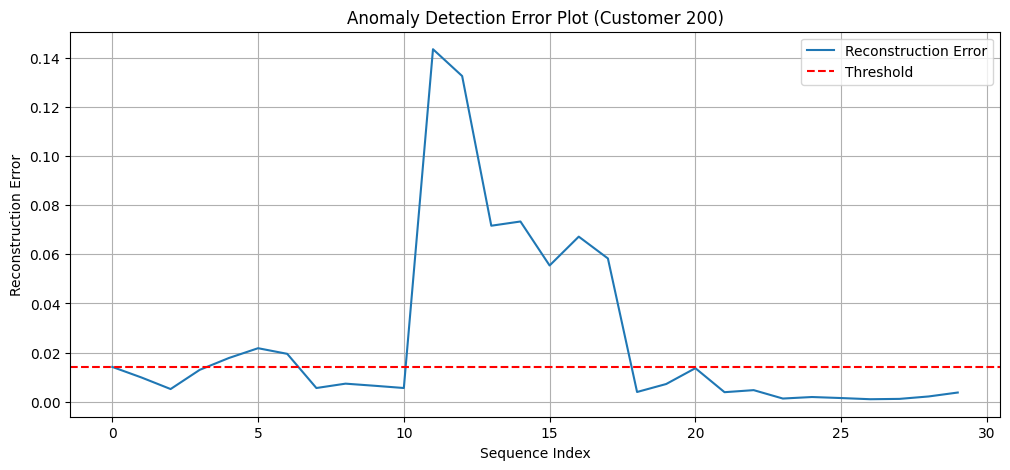

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test_mse, label="Reconstruction Error")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")

plt.title(f"Anomaly Detection Error Plot (Customer {cust_id})")
plt.xlabel("Sequence Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.show()


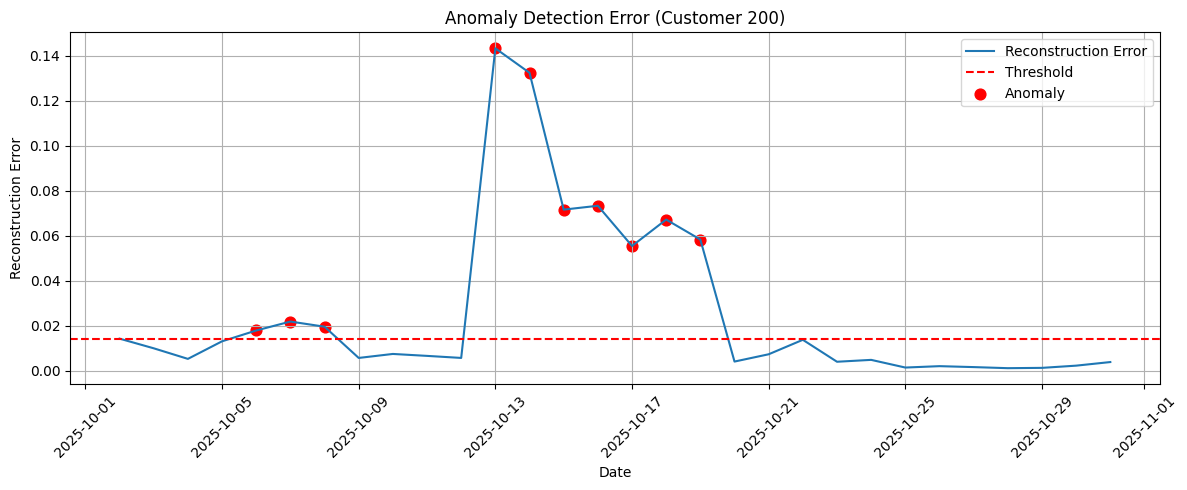

In [25]:
# 시퀀스에 대응되는 날짜 생성 (윈도우 마지막 날짜)
test_dates = ts.index[WINDOW_SIZE + split_point : WINDOW_SIZE + split_point + len(test_mse)]

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test_dates, test_mse, label="Reconstruction Error")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")

# 이상치 위치 표시
anomaly_dates = test_dates[anomaly_flags]
anomaly_values = test_mse[anomaly_flags]
plt.scatter(anomaly_dates, anomaly_values, color="red", s=60, label="Anomaly")

plt.title(f"Anomaly Detection Error (Customer {cust_id})")
plt.xlabel("Date")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [26]:
# 이상치 발생 날짜 리스트
anomaly_dates = test_dates[anomaly_flags]
print("이상 발생 날짜:")
print(anomaly_dates)


이상 발생 날짜:
DatetimeIndex(['2025-10-06', '2025-10-07', '2025-10-08', '2025-10-13',
               '2025-10-14', '2025-10-15', '2025-10-16', '2025-10-17',
               '2025-10-18', '2025-10-19'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [27]:
# 이상 날짜의 원본 데이터 필터링
abnormal_raw = df[
    (df["CustomerID"] == cust_id) &
    (df["Date"].isin(anomaly_dates))
]

# Subscription별 비용 집계
subscription_summary = abnormal_raw.groupby("MaskedSub")["TotalCost"].sum().sort_values(ascending=False)

print("📌 이상치 기간 Subscription별 비용:")
print(subscription_summary)


📌 이상치 기간 Subscription별 비용:
MaskedSub
sub_98f37001440b9a81    9.359976e+07
sub_2697df3e91ff01b5    3.162080e+07
Name: TotalCost, dtype: float64


In [28]:
target_sub = "sub_98f37001440b9a81"

sub_ts = (
    df[(df["CustomerID"] == cust_id) & (df["MaskedSub"] == target_sub)]
      .groupby("Date")["TotalCost"]
      .sum()
      .sort_index()
)

print(sub_ts.describe())


count    1.840000e+02
mean     8.545422e+06
std      4.261482e+06
min      5.575301e+06
25%      6.633748e+06
50%      7.112831e+06
75%      8.344655e+06
max      2.952632e+07
Name: TotalCost, dtype: float64


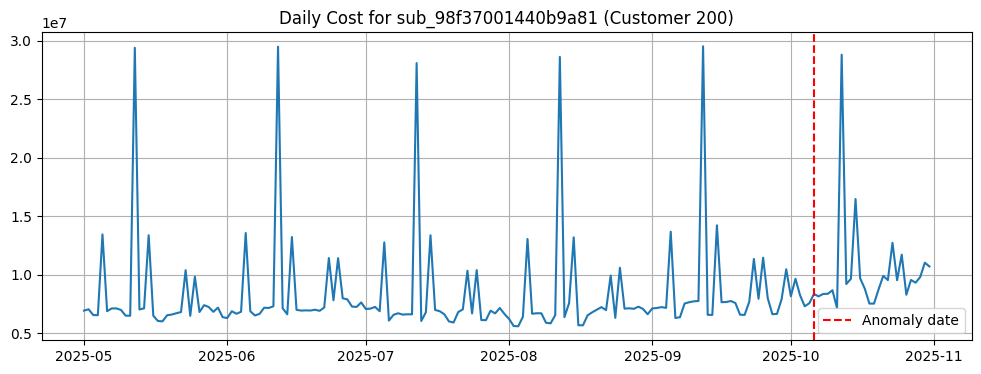

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(sub_ts.index, sub_ts.values)
plt.axvline(anomaly_dates.min(), color="red", linestyle="--", label="Anomaly date")
plt.title(f"Daily Cost for {target_sub} (Customer {cust_id})")
plt.legend()
plt.grid(True)
plt.show()


In [49]:
#  이상 날짜의 원본 데이터 (이미 만들어둔 abnormal_raw 재사용)
# abnormal_raw = df[
#     (df["CustomerID"] == cust_id) &
#     (df["Date"].isin(anomaly_dates))
# ]

# 구독 + MeterCategory + MeterSubCategory별 비용 집계
group_cols = ["MaskedSub", "MeterCategory", "MeterSubCategory"]

anomaly_detail = (
    abnormal_raw
    .groupby(group_cols)["TotalCost"]
    .sum()
    .reset_index()
    .sort_values("TotalCost", ascending=False)
)

print(" 이상 기간 구독 + 카테고리별 비용 상위 20개")
print(anomaly_detail.head(20))


 이상 기간 구독 + 카테고리별 비용 상위 20개
                MaskedSub                  MeterCategory  \
48   sub_2697df3e91ff01b5               Virtual Machines   
168  sub_98f37001440b9a81      Virtual Machines Licenses   
161  sub_98f37001440b9a81               Virtual Machines   
115  sub_98f37001440b9a81                        Storage   
57   sub_98f37001440b9a81            Application Gateway   
4    sub_2697df3e91ff01b5  Azure Database for PostgreSQL   
124  sub_98f37001440b9a81                     Unassigned   
102  sub_98f37001440b9a81           SQL Managed Instance   
121  sub_98f37001440b9a81                        Storage   
14   sub_2697df3e91ff01b5                    Redis Cache   
72   sub_98f37001440b9a81  Azure Database for PostgreSQL   
94   sub_98f37001440b9a81                    Redis Cache   
162  sub_98f37001440b9a81               Virtual Machines   
110  sub_98f37001440b9a81                        Storage   
158  sub_98f37001440b9a81               Virtual Machines   
166  sub_98f

In [50]:
target_sub = "sub_98f37001440b9a81"  # 확인하고 싶은 MaskedSub ID

sub_detail = (
    abnormal_raw[abnormal_raw["MaskedSub"] == target_sub]
    .groupby(["MeterCategory", "MeterSubCategory"])["TotalCost"]
    .sum()
    .reset_index()
    .sort_values("TotalCost", ascending=False)
)

print(f" {target_sub} 구독의 이상 기간 카테고리별 비용")
print(sub_detail.head(20))


 sub_98f37001440b9a81 구독의 이상 기간 카테고리별 비용
                     MeterCategory  \
113      Virtual Machines Licenses   
106               Virtual Machines   
60                         Storage   
2              Application Gateway   
69                      Unassigned   
47            SQL Managed Instance   
66                         Storage   
17   Azure Database for PostgreSQL   
39                     Redis Cache   
107               Virtual Machines   
55                         Storage   
103               Virtual Machines   
111      Virtual Machines Licenses   
78                Virtual Machines   
52                         Storage   
51                         Storage   
48            SQL Managed Instance   
46            SQL Managed Instance   
18                Azure Databricks   
108      Virtual Machines Licenses   

                                      MeterSubCategory     TotalCost  
113                                     Windows Server  4.171638e+06  
106               

In [51]:
total_anomaly_cost = anomaly_detail["TotalCost"].sum()

anomaly_detail["Ratio(%)"] = anomaly_detail["TotalCost"] / total_anomaly_cost * 100

print(" 이상 기간 구독+카테고리별 비용 비중 상위 20개")
print(anomaly_detail.head(20))


 이상 기간 구독+카테고리별 비용 비중 상위 20개
                MaskedSub                  MeterCategory  \
48   sub_2697df3e91ff01b5               Virtual Machines   
168  sub_98f37001440b9a81      Virtual Machines Licenses   
161  sub_98f37001440b9a81               Virtual Machines   
115  sub_98f37001440b9a81                        Storage   
57   sub_98f37001440b9a81            Application Gateway   
4    sub_2697df3e91ff01b5  Azure Database for PostgreSQL   
124  sub_98f37001440b9a81                     Unassigned   
102  sub_98f37001440b9a81           SQL Managed Instance   
121  sub_98f37001440b9a81                        Storage   
14   sub_2697df3e91ff01b5                    Redis Cache   
72   sub_98f37001440b9a81  Azure Database for PostgreSQL   
94   sub_98f37001440b9a81                    Redis Cache   
162  sub_98f37001440b9a81               Virtual Machines   
110  sub_98f37001440b9a81                        Storage   
158  sub_98f37001440b9a81               Virtual Machines   
166  sub_98